# Spiking multicompartment PC network

## Abstract
Predictive coding is a promising theoretical framework for understanding the hierarchical sensory processing in the brain, yet how it is implemented with cortical spiking neurons is still unclear. While most existing works have taken a hand-wiring approach to creating microcircuits which match experimental results, recent work in applying the optimisation approach revealed that cortical connectivity might result from self-organisation given some fundamental computational principle, ie. energy efficiency. We thus investigated whether predictive coding properties in a multicompartment spiking neural network can result from energy optimisation. We found that only the model trained with an energy objective in addition to a task-relevant objective was able to reconstruct internal representations given top-down expectation signals alone. Neurons in the energy-optimised model also showed differential responses to expected vs unexpected stimuli, qualitatively similar to experimental evidence for predictive coding. These findings indicated that predictive-coding-like behaviour might be an emergent property of energy optimisation, providing a new perspective on how predictive coding could be achieved in the cortex.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from predcoding.snn.network import EnergySNN
from predcoding.training import train_fptt, get_stats_named_params, reset_named_params
from predcoding.experiments.eval import test
from predcoding.experiments.decoder import train_decoder_classifier
from predcoding.utils import count_parameters, save_checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
torch.manual_seed(999)

cpu


## Setup

### Dataloaders

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

batch_size = 200

traindata = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testdata = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# data loading
train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, shuffle=False, num_workers=2)

### Defining the network

In [3]:
# network parameters
use_alif_neurons = True  # whether use adaptive neuron or not
clf_alpha = 1
energy_alpha = 0.05  # - config.clf_alpha
spike_alpha = 0.0  # energy loss on spikes
num_readout = 10
one_to_one = True
lr = 1e-3
alg = "fptt"
p_dropout = 0.4
is_recurrent = False
b_0 = 0.1      # neural threshold baseline
R_m = 3         # membrane resistance
gamma = 0.5     # gradient scale
lens = 0.5
baseline_threshold = b_0

# training parameters
T = 50
K = 10  # k_updates is num updates per sequence
omega = int(T / K)  # update frequency
clip = 1.0
log_interval = 20
epochs = 35
alpha = 0.2
beta = 0.5
rho = 0.0 

In [4]:
# set input and t param
d_in = 784
d_hidden = [600, 500, 500]
n_classes = 10

# define network
model = EnergySNN(
    d_in,
    d_hidden,
    d_out=n_classes,
    is_adaptive=use_alif_neurons,
    one_to_one=one_to_one,
    p_dropout=p_dropout,
    is_recurrent=is_recurrent,
    b0=b_0,
    device=device
)
model.to(device)
# print(model)

# define new loss and optimiser
total_params = count_parameters(model)
print("total param count %i" % total_params)

# define optimiser
optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=0.0001)
# reduce the learning after 20 epochs by a factor of 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

total param count 476020


## Clamping

In [5]:
from predcoding.utils import model_result_dict_load
saved_dict = model_result_dict_load('./checkpoints/best_model.pt.tar')
model.load_state_dict(saved_dict['state_dict'])

c:\Users\hoshelee\OneDrive - Rewire\Documents\Personal\University\NDDL\predictive-coding-snn\predcoding\utils.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = tor

<All keys matched successfully>

In [17]:
model.eval()
test(model, test_loader, T)

Test set: Average loss: 5.6595, Accuracy: 697/10000 (6.97%)


(5.659519763183594, tensor(6.9700))

In [7]:
# get params and put into dict
param_names_wE = []
param_dict_wE = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        param_names_wE.append(name)

print(param_names_wE)

['input_layer.weight', 'input_layer.bias', 'output_layer.tau_m', 'output_layer.fc.weight', 'output_layer.fc.bias']


In [9]:
from predcoding.experiments.decoder import get_states

# clamped generation of internal representations
no_input = torch.zeros((1, d_in)).to(device)
clamp_T = T * 5


l1_clamp_E = np.zeros((10, d_hidden[0]))
l2_clamp_E = np.zeros((10, d_hidden[1]))
l3_clamp_E = np.zeros((10, d_hidden[2]))


for i in tqdm(range(10)):
    with torch.no_grad():
        model.eval()

        hidden_i, readout_i = model.init_hidden(1)

        _, hidden_gen_E_ = model.clamped_generate(i, no_input, hidden_i, readout_i, clamp_T, clamp_value=1)

        #
        l1_E = get_states([hidden_gen_E_], 0, d_hidden[0], batch_size=1, T=clamp_T, num_samples=1)
        l2_E = get_states([hidden_gen_E_], 1, d_hidden[1], batch_size=1, T=clamp_T, num_samples=1)
        l3_E = get_states([hidden_gen_E_], 2, d_hidden[2], batch_size=1, T=clamp_T, num_samples=1)

        l1_clamp_E[i] += np.squeeze(l1_E.mean(axis=1))
        l2_clamp_E[i] += np.squeeze(l2_E.mean(axis=1))
        l3_clamp_E[i] += np.squeeze(l3_E.mean(axis=1))

    torch.cuda.empty_cache()

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

0 train loss: 0.2282


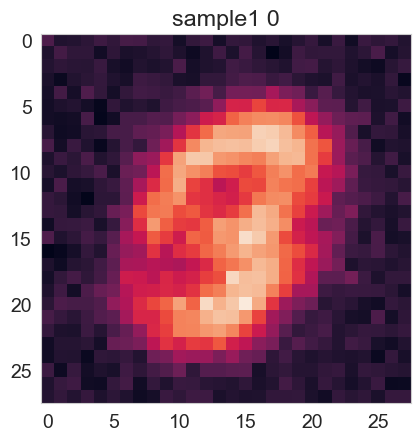

 10%|█         | 2/20 [01:18<11:51, 39.51s/it]

1 train loss: 0.2078


 15%|█▌        | 3/20 [01:58<11:14, 39.67s/it]

2 train loss: 0.1953


 20%|██        | 4/20 [02:40<10:50, 40.66s/it]

3 train loss: 0.1866


 25%|██▌       | 5/20 [03:25<10:31, 42.09s/it]

4 train loss: 0.1803
5 train loss: 0.1759


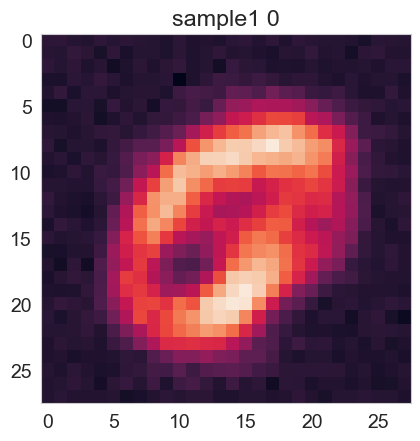

 35%|███▌      | 7/20 [04:45<08:53, 41.01s/it]

6 train loss: 0.1726


 40%|████      | 8/20 [05:25<08:07, 40.58s/it]

7 train loss: 0.1693


 45%|████▌     | 9/20 [06:03<07:18, 39.89s/it]

8 train loss: 0.1672


 50%|█████     | 10/20 [06:42<06:34, 39.50s/it]

9 train loss: 0.1652
10 train loss: 0.1634


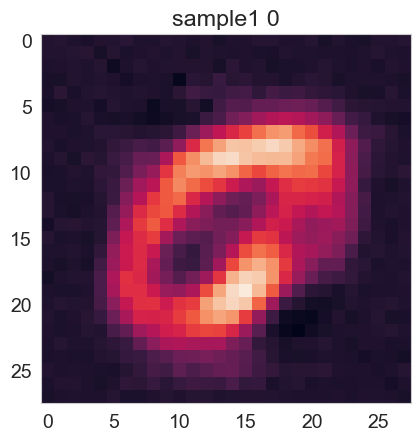

 60%|██████    | 12/20 [08:00<05:15, 39.46s/it]

11 train loss: 0.1625


 65%|██████▌   | 13/20 [08:38<04:32, 39.00s/it]

12 train loss: 0.1615


 70%|███████   | 14/20 [09:16<03:51, 38.56s/it]

13 train loss: 0.1596


 75%|███████▌  | 15/20 [09:55<03:13, 38.75s/it]

14 train loss: 0.1591
15 train loss: 0.1584


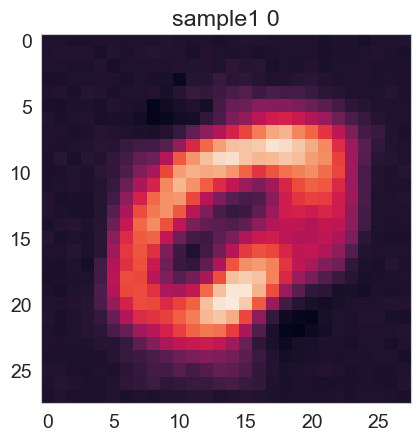

 85%|████████▌ | 17/20 [11:14<01:57, 39.02s/it]

16 train loss: 0.1578


 90%|█████████ | 18/20 [11:53<01:17, 38.88s/it]

17 train loss: 0.1568


 95%|█████████▌| 19/20 [12:31<00:38, 38.54s/it]

18 train loss: 0.1563


100%|██████████| 20/20 [13:08<00:00, 39.44s/it]

19 train loss: 0.1561


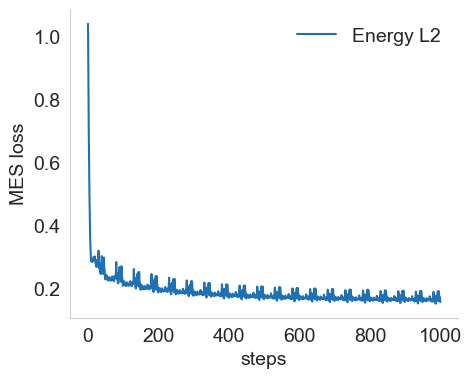

In [15]:
##############################################################
# decode from clamped representations
##############################################################
no_input = torch.zeros((1, d_in)).to(device)

fn_loss = nn.MSELoss()
test_loader2 = torch.utils.data.DataLoader(
    testdata, batch_size=batch_size, shuffle=False, num_workers=2
)

# %%
def plot_projection(rep, label, weights, bias):
    img = (weights @ rep + bias).reshape(28, 28)
    plt.imshow(img)
    plt.title(str(label))
    plt.show()
    return img


# %%
layer = 1
l2_E_decoder, loss_E = train_decoder_classifier(
    20, layer, model, test_loader2, d_hidden[layer], d_in, batch_size, T, device, fn_loss
)

decoders = [l2_E_decoder]

# %%
# plot loss curve of training
colors = [
    (0.1271049596309112, 0.4401845444059977, 0.7074971164936563),
    (0.9949711649365629, 0.5974778931180315, 0.15949250288350636),
]
sns.set_style("whitegrid", {"axes.grid": False})

fig, ax = plt.subplots(figsize=(5, 4))
plt.rcParams.update({"font.size": 14})

ax.plot(loss_E, label="Energy L%i" % (layer + 1), color=colors[0])
ax.legend()
# frame off
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("MES loss")
ax.set_xlabel("steps")
plt.legend(frameon=False)
# increase font size
plt.show()

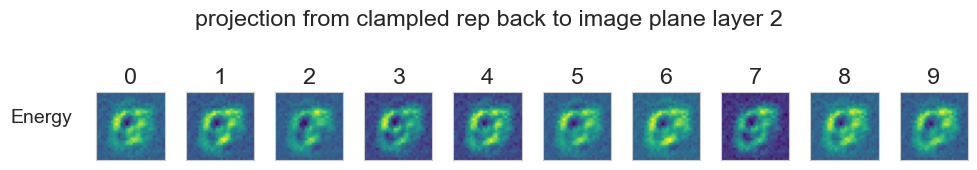

In [16]:
# plot decoding of clamped internal representations
fig, axes = plt.subplots(1, 10, figsize=(10, 2))

with torch.no_grad():
    for proj_class in range(n_classes):
        img1 = (
            decoders[0](
                torch.tensor(l2_clamp_E[proj_class].astype("float32"))
                .to(device)
                .view(-1, d_hidden[layer])
            )
            .reshape(28, 28)
            .cpu()
        )
        axes[proj_class].imshow(img1, cmap="viridis")
        axes[proj_class].set_title(str(proj_class))
        # axes[0][proj_class].axis('off')
        axes[proj_class].tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )

fig.suptitle("projection from clampled rep back to image plane layer %i" % (layer + 1))
axes[0].set_ylabel("Energy", rotation=0, labelpad=40)

plt.tight_layout()
plt.show()